In [8]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("MEDIAN_CENTERED"),index_col=0)

zscored_df = pd.read_csv(os.getenv("ZSCORED"),index_col=0)

clinical_df = pd.read_csv(os.getenv("CLINICAL"),index_col=0)

# Set title as index
#clinical_df_indexed = clinical_df.set_index("title")
clinical_df_indexed = clinical_df.copy()

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Select and clean clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

# Keep numeric clinical columns only
clinical_features = clinical_df_indexed.select_dtypes(include=[np.number]).drop(columns=[col for col in id_columns if col in clinical_df_indexed.columns])

# Align sample indices
clinical_features = clinical_features.loc[zscored_df.index]

# --- Step 1: Separate column types ---
onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

# --- Step 2: Impute missing values ---
imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(imp_num.fit_transform(clinical_features[numeric_cols]), 
                                columns=numeric_cols, index=clinical_features.index)

clinical_onehot = pd.DataFrame(imp_bin.fit_transform(clinical_features[onehot_cols]), 
                               columns=onehot_cols, index=clinical_features.index)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       611
         1.0       0.61      0.15      0.25        71

    accuracy                           0.90       682
   macro avg       0.76      0.57      0.60       682
weighted avg       0.88      0.90      0.87       682

Confusion Matrix:
 [[604   7]
 [ 60  11]]
ROC AUC Score: 0.7876259191812083


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


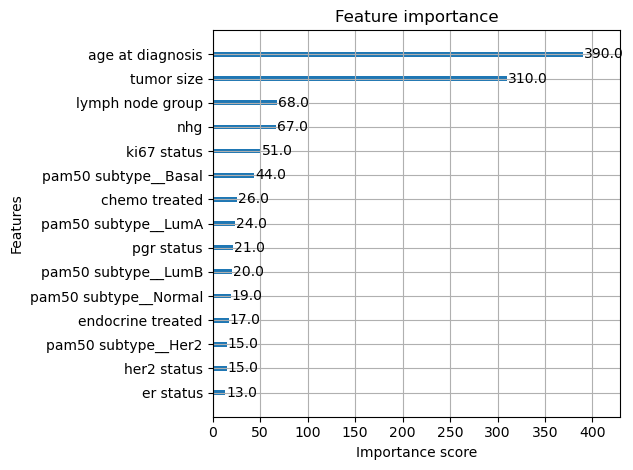

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 3: Define target ---
target_col = 'overall survival event'  # example target
y = clinical_df_indexed.loc[clinical_imputed.index, target_col]

# Drop NA samples from target
X = clinical_imputed.loc[~y.isna()].drop(columns=[target_col, 'overall survival days'], errors='ignore')
y = y.dropna()

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 5: XGBoost classifier ---
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
)

model.fit(X_train, y_train)

# --- Step 6: Evaluation ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# --- Optional: Feature importance plot ---
xgb.plot_importance(model, max_num_features=15)
plt.tight_layout()
plt.show()
